In [88]:
#Import dépendances
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.types import DoubleType
spark = SparkSession.builder.getOrCreate()

import numpy as np
import matplotlib.pyplot as plt

import numpy as np

In [ ]:
pip install kaggle

In [174]:
import kaggle
import zipfile

from kaggle.api.kaggle_api_extended import KaggleApi
api = KaggleApi()
api.authenticate()

api.dataset_download_files('austinreese/craigslist-carstrucks-data', path='./data/vehicles/')

with zipfile.ZipFile('./data/vehicles/craigslist-carstrucks-data.zip', 'r') as zipref:
    zipref.extractall('./data/vehicles/')

In [123]:
#Chargement du fichier
#path = "./data/vehicles/vehicles_min.csv"
path = "./data/vehicles/vehicles.csv"
df = spark.read.format('csv').options(header=True).load(path)
df.count()


475057

In [ ]:
#Tentative de split d'un gros fichier en plusieurs fichiers

#Chargement du fichier
#path = "./data/vehicles/vehicles"
#df = spark.read.format('csv').options(header=True).load(path)
#df.count()

#On récupère 20% du dataFrame initial
#df_sample = df.sample(0.2)

#Sur le DF récupéré, on le partionne en 50 partitions
#df_aftercut = df_sample.coalesce(50)

#On écrit un fichier .csv pour chaque partition
#df_aftercut.write.format("csv").option("header", "true").save("./data/vehicles/vehicles_cut/")

#Nouveau path avec le DF partitionné
#path_cut = "./data/vehicles/vehicles_cut/*.csv"
#df_cut = spark.read.format('csv').options(header=True).load(path_cut)
#df_cut.printSchema()

In [ ]:
# |||
# VERSION FICHIER 5000 LIGNES
# ||| 

In [124]:
df.count()
df.head()
df.printSchema()


root
 |-- _c0: string (nullable = true)
 |-- id: string (nullable = true)
 |-- url: string (nullable = true)
 |-- region: string (nullable = true)
 |-- region_url: string (nullable = true)
 |-- price: string (nullable = true)
 |-- year: string (nullable = true)
 |-- manufacturer: string (nullable = true)
 |-- model: string (nullable = true)
 |-- condition: string (nullable = true)
 |-- cylinders: string (nullable = true)
 |-- fuel: string (nullable = true)
 |-- odometer: string (nullable = true)
 |-- title_status: string (nullable = true)
 |-- transmission: string (nullable = true)
 |-- VIN: string (nullable = true)
 |-- drive: string (nullable = true)
 |-- size: string (nullable = true)
 |-- type: string (nullable = true)
 |-- paint_color: string (nullable = true)
 |-- image_url: string (nullable = true)
 |-- description: string (nullable = true)
 |-- state: string (nullable = true)
 |-- lat: string (nullable = true)
 |-- long: string (nullable = true)
 |-- posting_date: string (nulla

In [125]:
# Les champs contenant des liens polluants la data
cases = df.select('url','region_url','image_url')
cases.show()


+--------------------+--------------------+--------------------+
|                 url|          region_url|           image_url|
+--------------------+--------------------+--------------------+
|https://auburn.cr...|https://auburn.cr...|https://images.cr...|
|https://auburn.cr...|https://auburn.cr...|https://images.cr...|
|https://auburn.cr...|https://auburn.cr...|https://images.cr...|
|https://auburn.cr...|https://auburn.cr...|https://images.cr...|
|https://auburn.cr...|https://auburn.cr...|https://images.cr...|
|https://auburn.cr...|https://auburn.cr...|https://images.cr...|
|https://auburn.cr...|https://auburn.cr...|https://images.cr...|
|https://auburn.cr...|https://auburn.cr...|https://images.cr...|
|https://auburn.cr...|https://auburn.cr...|https://images.cr...|
|https://auburn.cr...|https://auburn.cr...|https://images.cr...|
|https://auburn.cr...|https://auburn.cr...|https://images.cr...|
|https://auburn.cr...|https://auburn.cr...|https://images.cr...|
|https://auburn.cr...|htt

In [126]:
# Suppression de certains champs inutiles
df = df.drop('url')
df = df.drop('region_url') 
df = df.drop('image_url')
df = df.drop('description')

In [127]:
df.head()

Row(_c0='0', id='7240372487', region='auburn', price='35990', year='2010.0', manufacturer='chevrolet', model='corvette grand sport', condition='good', cylinders='8 cylinders', fuel='gas', odometer='32742.0', title_status='clean', transmission='other', VIN='1G1YU3DW1A5106980', drive='rwd', size=None, type='other', paint_color=None, state='al', lat='32.59', long='-85.48', posting_date='2020-12-02T08:11:30-0600')

+--------------------+-------------+
|              region|count(region)|
+--------------------+-------------+
|huntsville / decatur|         1373|
|florence / muscle...|          115|
|              mobile|         1011|
|          montgomery|          137|
|              dothan|          330|
|          birmingham|         2072|
|    gadsden-anniston|          206|
|              auburn|           88|
+--------------------+-------------+



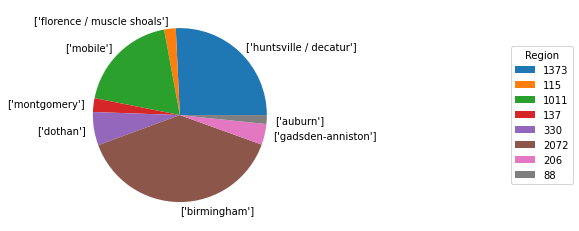

In [131]:
#Présentation de la data

path = "./data/vehicles/vehicles_min.csv"
#path = "./data/vehicles/vehicles.csv"
df = spark.read.format('csv').options(header=True).load(path)

#Répartition des voitures en fonction des régions, avec représentation graphique
df_region_name = df.select("region").distinct().collect()
df_region_values = df.groupBy("region").agg({"region":"count"}).withColumnRenamed("COUNT(region)", "nb")

arr_region_name = np.array(df_region_name)
arr_region_values = df_region_values.select("nb").collect()

values_matplot = np.array(arr_region_values)
values_matplot = values_matplot.flatten()
plt.pie(values_matplot, labels = arr_region_name, normalize = True)
plt.legend(values_matplot, title="Region", loc="center left", bbox_to_anchor=(2, 0, 0.5, 1))

df.groupBy("region").agg({"region": "count"}).show()

+--------+-----------+
|    fuel|count(fuel)|
+--------+-----------+
|     gas|       4760|
|   other|         73|
|  diesel|        373|
|  hybrid|         47|
|electric|         20|
+--------+-----------+



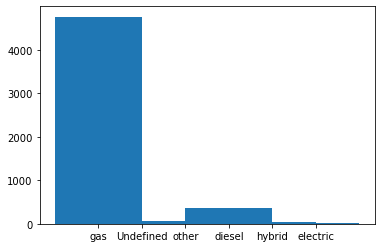

In [132]:
path = "./data/vehicles/vehicles_min.csv"
#path = "./data/vehicles/vehicles.csv"
df = spark.read.format('csv').options(header=True).load(path)

#Repartition des voitures en fonction du carburant, avec représentation graphique
df_fuel_name = df.select("fuel").distinct().na.fill('Undefined').collect()
df_fuel_values = df.groupBy("fuel").agg({"fuel":"count"}).withColumnRenamed("COUNT(fuel)", "nb")

arr_fuel_name = np.array(df_fuel_name)
arr_fuel_values = df_fuel_values.select("nb").collect()

values_matplot = np.array(arr_fuel_values)
values_matplot = values_matplot.flatten()


plt.bar(arr_fuel_name.flatten(), values_matplot, width= 2, align='center')

df.groupBy("fuel").agg({"fuel": "count"}).where(F.col("fuel").isNotNull()).show()

+-----------+-----------+
|       type|count(type)|
+-----------+-----------+
|        van|        126|
|   mini-van|         57|
|    offroad|         11|
|      wagon|         54|
|       null|          0|
|      coupe|        237|
|        bus|         25|
|        SUV|        903|
|      other|        162|
|convertible|         87|
|      sedan|        857|
|  hatchback|        101|
|      truck|        485|
|     pickup|        449|
+-----------+-----------+



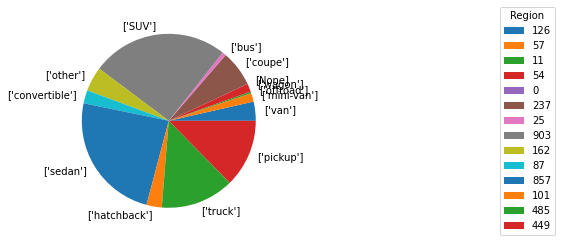

In [133]:
path = "./data/vehicles/vehicles_min.csv"
#path = "./data/vehicles/vehicles.csv"
df = spark.read.format('csv').options(header=True).load(path)

#Répartition des voitures en fonction des types de véhicule, avec représentation graphique
df_type_name = df.select("type").distinct().collect()
df_type_values = df.groupBy("type").agg({"type":"count"}).withColumnRenamed("COUNT(type)", "nb")

arr_type_name = np.array(df_type_name)
arr_type_values = df_type_values.select("nb").collect()

values_matplot = np.array(arr_type_values)
values_matplot = values_matplot.flatten()
plt.pie(values_matplot, labels = arr_type_name, normalize = True)
plt.legend(values_matplot, title="Region", loc="center left", bbox_to_anchor=(2, 0, 0.5, 1))

df.groupBy("type").agg({"type": "count"}).show()

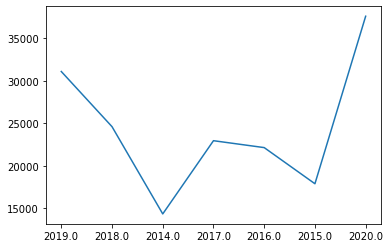

In [173]:
path = "./data/vehicles/vehicles_min.csv"
#path = "./data/vehicles/vehicles.csv"
df = spark.read.format('csv').options(header=True).load(path)
df = df.dropna()

df = df.filter(df["year"] > "2013.0")

df_avg = df.groupBy("year").agg({"price":"mean"}).withColumnRenamed("COUNT(year)", "year")
df_price = df_avg.select("avg(price)").collect()
df_year = df_avg.select("year").collect()

arr_price = np.array(df_price) 
arr_year = np.array(df_year)

plt.plot(arr_year.flatten(), arr_price.flatten())